# モデル選定に関する収益ノートブック

## パラメータで選択したモデルたちがどんなものなのか実際に確認する

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
from sklearn.model_selection import train_test_split
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
import time
import datetime
from dateutil.relativedelta import relativedelta
import os #ディレクトリ作成用
import xgboost as xgb
import sys
from sklearn.preprocessing import StandardScaler#モデルの評価用に標準化する関数
import scipy.stats#モデルの評価用に標準化する関数
import warnings

#自作のモジュールのインポート
sys.path.append("..")
import module.master as master
import module.modeling_scores as modeling


# 関数

In [19]:
def add_std_score(good_model_df,feature_weights):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df


def select_use_model(model_std_score_df):#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_model_df=pd.DataFrame()
    for com in sorted(model_std_score_df['target_com'].value_counts().index):
        target_com_df=model_std_score_df[model_std_score_df['target_com']==com].copy()
        com_selected_row=target_com_df.sort_values('score', ascending=False).iloc[:1]
        #use_model_df=pd.concat([use_model_df, com_selected_row], axis=0)#きめのパラメータで切り落としたので結合
        use_model_df=use_model_df.append(com_selected_row,ignore_index=True)
    return use_model_df


def twin_plt(x,y1,y2,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    
    ax1 = fig.add_subplot()
    fig.set_facecolor(color='white')
    ax1.plot(x, y1,label=y1_n)
    ax1.tick_params()
    plt.ylim(80, 200)
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red')
    ax1.axhline(100,ls = "-.",color='green')
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower center')

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

## きめのパラメータでモデルを大ざっぱに切り落としたのちに，相関係数とスケーリングした標準偏差をもとに最終的に使用するモデルを決定する(芦屋のみ)

In [20]:
# 芦屋だけでひとまず機能を完成させる
#きめのパラメータ
place_name='asiya'
plus_m_th=3
num_hit_th=5
version='V4_2'
mode='asiya_model_score_'
mode_type='recent'
csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)

#閾値の取得
th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
#th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]

dates=[datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d') for i in range(4)]#今回のテストで使用する日付たち

#th_s=totol_analysis_df[(totol_analysis_df['num_plus_com_mean']>3) & (totol_analysis_df['num_hit_th']>=10)].sort_values('minus_model_per_mean').iloc[0]
select_model_df=pd.DataFrame()
#閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
for i in range(4):
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
    model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
    model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
    #選定したパラメータで切り落とし

    
    selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
    selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
    selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
    selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
    selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
    print(now_ym,'=============================================')
    #display(selected_m)
    select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
    #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
    use_date=dates[i-1]#一つ前の区間の日付を切り抜く
    dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=use_date,version=version)
    print(dir_path)
    model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
    model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
     #決めのパラメータでいったん切り落とし
    model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
    model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
    version_corr_df=model_score_df.corr()
    feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
    print('now_date:',now_ym)
    print('corr_date:',use_date)
    
    print(feature_weights)
    model_score_df=add_std_score(select_model_df,feature_weights)
    
    
    use_models=select_use_model(model_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_models.to_csv('csv/use_model_df_{}.csv'.format(now_ym))
    dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
    use_models.to_csv(dir_path.format(now_ym))

20200101 =============================================
../../bot_database/asiya/model_score_asiya/v4_score/V4_2/asiya_model_score_st20201001_finalM3_V4_2.csv
now_date: 20200101
corr_date: 20201001
total_get_test         -0.082876
total_use_test          0.128850
num_com_test           -0.236045
num_pred_test           0.128850
gain_test              -0.437073
gain_std_test          -0.150581
num_hit_test           -0.103681
buy_hit_per_test       -0.158518
buy_hit_per_std_test   -0.161160
plus_month_num_test    -0.119610
diff_mea_med_test      -0.142288
Name: gain_final, dtype: float64
20200401 =============================================
../../bot_database/asiya/model_score_asiya/v4_score/V4_2/asiya_model_score_st20200101_finalM3_V4_2.csv
now_date: 20200401
corr_date: 20200101
total_get_test         -0.240265
total_use_test         -0.411209
num_com_test           -0.444301
num_pred_test          -0.411209
gain_test               0.193461
gain_std_test           0.403796
num_hit_test

## 各シーズンごとの収益とcom数の推移(選定された全モデル)

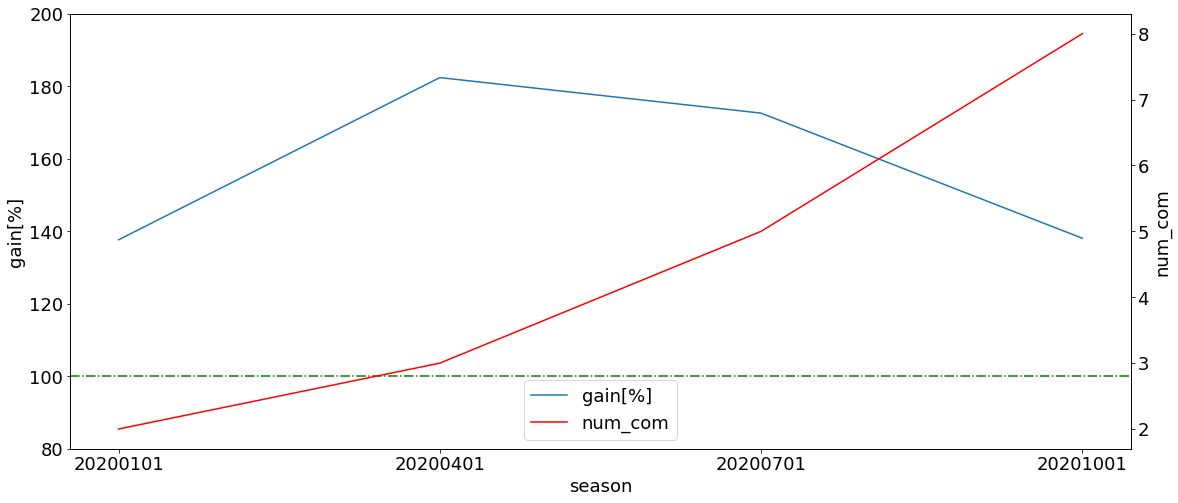

In [21]:
gain_arr=[0]*4
n_com_arr=[0]*4
date_arr=[0]*4
for i in range(4):
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    dir_path='csv/use_model_df_{}.csv'.format(now_ym)
    use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
    #display(use_models)
    s_t_use=use_models['total_use_final'].sum()
    s_t_get=use_models['total_get_final'].sum()
    s_gain=(s_t_get/s_t_use)*100
    gain_arr[i]=s_gain
    n_com_arr[i]=len(use_models)
    date_arr[i]=now_ym
x_n='season'
y1_n='gain[%]'
y2_n='num_com'
twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

In [22]:
th_s

minus_model_per_mean                22.247024
num_plus_com_mean                    2.250000
num_plus_model_mean                 39.000000
gain_th                            140.000000
gain_std_th                        160.000000
hit_per_th                           4.000000
hit_std_th                           0.800000
num_hit_th                           3.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             2.000000
st_20200101_num_plus_model(row)      2.000000
st_20200401_minus_per(model)         0.000000
st_20200401_num_plus_com             1.000000
st_20200401_num_plus_model(row)     11.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             3.000000
st_20200701_num_plus_model(row)    106.000000
st_20201001_minus_per(model)        88.988095
st_20201001_num_plus_com             3.000000
st_20201001_num_plus_model(row)     37.000000
Name: 100019, dtype: float64

# 多会場版（いったんモデリングが済んでいる１０会場で．）

In [23]:
version='V4_2'#バージョン
#use_modelの書き込み先作成のための箱作り
place_master=master.get_place_master()
for place in place_master.items():
    #print(place[0],place[1],'\n')
    place_name=place[1]
    dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}".format(place_name=place_name,version=version)#作成したデータの書き込み先#使用するデータの読み込み
    if os.path.exists(dir_path)==False:
        os.makedirs(dir_path)
    else:
        pass

In [24]:
warnings.simplefilter('ignore')
#相関係数と全体分析の結果をもとに最終的に使用するモデルを選定する
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
plus_m_th=2
#plus_m_th=3
num_hit_th=5
version='V4_2'
mode='model_score_'
mode_type='recent'
#コード本文
for place_name in place_names[:10]:
    csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
    totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
    totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)
    print('place_name:',place_name,'========================================================================================')
    #閾値の取得
    th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    display(th_s)
    dates=[datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d') for i in range(4)]#今回のテストで使用する日付たち
    select_model_df=pd.DataFrame()
    
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        print('now_date:',now_ym)
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #選定したパラメータで切り落とし
        selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
        selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
        selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
        select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
        
        
#         #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
        use_date=dates[i-1]#一つ前の区間の日付を切り抜く
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=use_date,version=version)
        #print(dir_path)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #決めのパラメータでいったん切り落とし
        model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
        model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
        version_corr_df=model_score_df.corr()
        feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
        print(feature_weights)
        #display(feature_weights)
        model_std_score_df=add_std_score(select_model_df,feature_weights)
        if place_name=='toda':
            model_std_score_df.to_csv('csv/toda_{dt}.csv'.format(dt=now_ym))
        use_models=select_use_model(model_std_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        use_models.to_csv(dir_path)

place_name: kiryu ========================================================================================


minus_model_per_mean                62.135142
num_plus_com_mean                    4.750000
num_plus_model_mean                122.250000
gain_th                            100.000000
gain_std_th                        130.000000
hit_per_th                           0.000000
hit_std_th                           0.400000
num_hit_th                           3.000000
st_20200101_minus_per(model)        47.596154
st_20200101_num_plus_com            10.000000
st_20200101_num_plus_model(row)    218.000000
st_20200401_minus_per(model)        66.855524
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)    117.000000
st_20200701_minus_per(model)        77.200000
st_20200701_num_plus_com             5.000000
st_20200701_num_plus_model(row)     57.000000
st_20201001_minus_per(model)        56.888889
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_model(row)     97.000000
Name: 4401, dtype: float64

now_date: 20200101
total_get_test          0.200673
total_use_test          0.009252
num_com_test           -0.673008
num_pred_test           0.009252
gain_test               0.251505
gain_std_test           0.422290
num_hit_test           -0.341734
buy_hit_per_test       -0.462477
buy_hit_per_std_test    0.159487
plus_month_num_test    -0.234534
diff_mea_med_test      -0.011766
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.183240
total_use_test         -0.306624
num_com_test           -0.079752
num_pred_test          -0.306624
gain_test               0.184908
gain_std_test           0.539687
num_hit_test           -0.114220
buy_hit_per_test        0.089459
buy_hit_per_std_test    0.130295
plus_month_num_test    -0.137310
diff_mea_med_test      -0.064851
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.096598
total_use_test         -0.163600
num_com_test            0.231963
num_pred_test          -0.163600
gain_test          

minus_model_per_mean               16.954685
num_plus_com_mean                   2.250000
num_plus_model_mean                20.750000
gain_th                            96.000000
gain_std_th                        85.000000
hit_per_th                          6.000000
hit_std_th                          1.600000
num_hit_th                          5.000000
st_20200101_minus_per(model)        9.523810
st_20200101_num_plus_com            3.000000
st_20200101_num_plus_model(row)    38.000000
st_20200401_minus_per(model)       35.714286
st_20200401_num_plus_com            2.000000
st_20200401_num_plus_model(row)     9.000000
st_20200701_minus_per(model)       22.580645
st_20200701_num_plus_com            2.000000
st_20200701_num_plus_model(row)    24.000000
st_20201001_minus_per(model)        0.000000
st_20201001_num_plus_com            2.000000
st_20201001_num_plus_model(row)    12.000000
Name: 23469, dtype: float64

now_date: 20200101
total_get_test          0.289617
total_use_test         -0.121807
num_com_test            0.088846
num_pred_test          -0.121807
gain_test               0.407522
gain_std_test           0.431455
num_hit_test            0.106482
buy_hit_per_test        0.152946
buy_hit_per_std_test    0.087297
plus_month_num_test     0.186065
diff_mea_med_test      -0.417123
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.061033
total_use_test          0.013634
num_com_test            0.252722
num_pred_test           0.013634
gain_test               0.059339
gain_std_test           0.398192
num_hit_test            0.017281
buy_hit_per_test        0.012094
buy_hit_per_std_test    0.431983
plus_month_num_test    -0.341734
diff_mea_med_test       0.150974
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.160664
total_use_test         -0.126350
num_com_test           -0.318119
num_pred_test          -0.126350
gain_test          

minus_model_per_mean                30.134409
num_plus_com_mean                    2.250000
num_plus_model_mean                 12.250000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           4.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        36.666667
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)     19.000000
st_20200401_minus_per(model)        83.870968
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     25.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      1.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_plus_model(row)      4.000000
Name: 36613, dtype: float64

now_date: 20200101
total_get_test         -0.356342
total_use_test         -0.384763
num_com_test            0.252481
num_pred_test          -0.384763
gain_test               0.000345
gain_std_test          -0.271461
num_hit_test            0.063983
buy_hit_per_test        0.368475
buy_hit_per_std_test    0.205457
plus_month_num_test     0.173960
diff_mea_med_test      -0.126243
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.039488
total_use_test         -0.064439
num_com_test            0.071213
num_pred_test          -0.064439
gain_test               0.068928
gain_std_test           0.202996
num_hit_test           -0.054804
buy_hit_per_test       -0.042214
buy_hit_per_std_test   -0.084304
plus_month_num_test    -0.111242
diff_mea_med_test       0.011801
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.264987
total_use_test          0.039464
num_com_test           -0.342509
num_pred_test           0.039464
gain_test          

minus_model_per_mean                49.935985
num_plus_com_mean                    2.500000
num_plus_model_mean                 23.000000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        85.416667
st_20200101_num_plus_com             2.000000
st_20200101_num_plus_model(row)      7.000000
st_20200401_minus_per(model)         0.000000
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)      9.000000
st_20200701_minus_per(model)        72.727273
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        41.600000
st_20201001_num_plus_com             4.000000
st_20201001_num_plus_model(row)     73.000000
Name: 56607, dtype: float64

now_date: 20200101
total_get_test         -0.331811
total_use_test         -0.279431
num_com_test            0.005752
num_pred_test          -0.279431
gain_test               0.000658
gain_std_test           0.103491
num_hit_test           -0.153694
buy_hit_per_test        0.135890
buy_hit_per_std_test    0.418363
plus_month_num_test    -0.148703
diff_mea_med_test      -0.394866
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.415810
total_use_test         -0.203399
num_com_test            0.053784
num_pred_test          -0.203399
gain_test              -0.309611
gain_std_test          -0.021112
num_hit_test           -0.006235
buy_hit_per_test        0.096557
buy_hit_per_std_test    0.239229
plus_month_num_test    -0.089371
diff_mea_med_test      -0.243153
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.074861
total_use_test          0.014911
num_com_test            0.068123
num_pred_test           0.014911
gain_test          

minus_model_per_mean                35.136901
num_plus_com_mean                    2.500000
num_plus_model_mean                 52.250000
gain_th                            108.000000
gain_std_th                        115.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)    109.000000
st_20200401_minus_per(model)        92.721519
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)     23.000000
st_20200701_minus_per(model)        47.826087
st_20200701_num_plus_com             4.000000
st_20200701_num_plus_model(row)     72.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_plus_model(row)      5.000000
Name: 45968, dtype: float64

now_date: 20200101
total_get_test         -0.182407
total_use_test         -0.190287
num_com_test            0.090512
num_pred_test          -0.190287
gain_test              -0.032814
gain_std_test          -0.104496
num_hit_test           -0.013271
buy_hit_per_test        0.306910
buy_hit_per_std_test    0.345378
plus_month_num_test    -0.040807
diff_mea_med_test       0.023570
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.102356
total_use_test         -0.157327
num_com_test            0.029481
num_pred_test          -0.157327
gain_test               0.307864
gain_std_test           0.261075
num_hit_test            0.002535
buy_hit_per_test        0.170586
buy_hit_per_std_test    0.042212
plus_month_num_test     0.219195
diff_mea_med_test      -0.021454
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.096323
total_use_test          0.031015
num_com_test            0.251075
num_pred_test           0.031015
gain_test          

minus_model_per_mean                51.939811
num_plus_com_mean                    2.250000
num_plus_model_mean                 24.750000
gain_th                            124.000000
gain_std_th                        235.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        28.571429
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)     55.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        79.187817
st_20201001_num_plus_com             4.000000
st_20201001_num_plus_model(row)     41.000000
Name: 49557, dtype: float64

now_date: 20200101
total_get_test          0.005243
total_use_test          0.146283
num_com_test           -0.387656
num_pred_test           0.146283
gain_test              -0.139846
gain_std_test          -0.131705
num_hit_test            0.011277
buy_hit_per_test       -0.121615
buy_hit_per_std_test   -0.275796
plus_month_num_test    -0.252799
diff_mea_med_test      -0.291274
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.066046
total_use_test          0.222537
num_com_test            0.495555
num_pred_test           0.222537
gain_test              -0.082567
gain_std_test          -0.130789
num_hit_test            0.445356
buy_hit_per_test        0.240348
buy_hit_per_std_test    0.017235
plus_month_num_test     0.187776
diff_mea_med_test       0.190083
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.189996
total_use_test          0.032515
num_com_test            0.255817
num_pred_test           0.032515
gain_test          

minus_model_per_mean                33.069829
num_plus_com_mean                    2.250000
num_plus_model_mean                 48.000000
gain_th                            108.000000
gain_std_th                        130.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        23.188406
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)    159.000000
st_20200401_minus_per(model)         9.090909
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     30.000000
st_20200701_minus_per(model)       100.000000
st_20200701_num_plus_com             0.000000
st_20200701_num_plus_model(row)      0.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_plus_model(row)      3.000000
Name: 26018, dtype: float64

now_date: 20200101
total_get_test         -0.350016
total_use_test          0.146573
num_com_test            0.189818
num_pred_test           0.146573
gain_test              -0.666930
gain_std_test           0.147541
num_hit_test           -0.146469
buy_hit_per_test       -0.422898
buy_hit_per_std_test   -0.386368
plus_month_num_test    -0.502294
diff_mea_med_test       0.207218
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.313227
total_use_test         -0.250924
num_com_test            0.344404
num_pred_test          -0.250924
gain_test              -0.038465
gain_std_test          -0.318862
num_hit_test            0.214450
buy_hit_per_test        0.496081
buy_hit_per_std_test    0.465607
plus_month_num_test     0.257884
diff_mea_med_test      -0.311481
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.272429
total_use_test         -0.024965
num_com_test           -0.141486
num_pred_test          -0.024965
gain_test          

minus_model_per_mean                39.015152
num_plus_com_mean                    2.250000
num_plus_model_mean                 22.000000
gain_th                            144.000000
gain_std_th                        160.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           3.000000
st_20200101_minus_per(model)        39.393939
st_20200101_num_plus_com             5.000000
st_20200101_num_plus_model(row)     80.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)        16.666667
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      5.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_model(row)      3.000000
Name: 13314, dtype: float64

now_date: 20200101
total_get_test         -0.404286
total_use_test          0.022738
num_com_test           -0.201481
num_pred_test           0.022738
gain_test              -0.422652
gain_std_test          -0.461313
num_hit_test           -0.139343
buy_hit_per_test       -0.192814
buy_hit_per_std_test   -0.349231
plus_month_num_test     0.081438
diff_mea_med_test      -0.490271
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.173832
total_use_test         -0.097496
num_com_test           -0.121616
num_pred_test          -0.097496
gain_test              -0.019037
gain_std_test          -0.216762
num_hit_test            0.008429
buy_hit_per_test        0.158264
buy_hit_per_std_test    0.029148
plus_month_num_test     0.019837
diff_mea_med_test      -0.135740
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test         -0.061227
total_use_test         -0.049506
num_com_test           -0.189779
num_pred_test          -0.049506
gain_test          

minus_model_per_mean                26.960784
num_plus_com_mean                    2.250000
num_plus_model_mean                  7.000000
gain_th                            148.000000
gain_std_th                        175.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             1.000000
st_20200101_num_plus_model(row)      8.000000
st_20200401_minus_per(model)        41.666667
st_20200401_num_plus_com             3.000000
st_20200401_num_plus_model(row)      7.000000
st_20200701_minus_per(model)        41.176471
st_20200701_num_plus_com             3.000000
st_20200701_num_plus_model(row)     10.000000
st_20201001_minus_per(model)        25.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_model(row)      3.000000
Name: 54164, dtype: float64

now_date: 20200101
total_get_test         -0.050486
total_use_test          0.427148
num_com_test            0.541494
num_pred_test           0.427148
gain_test              -0.551358
gain_std_test          -0.499849
num_hit_test            0.535108
buy_hit_per_test        0.262191
buy_hit_per_std_test   -0.114400
plus_month_num_test    -0.518637
diff_mea_med_test       0.093313
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test          0.349733
total_use_test          0.129576
num_com_test            0.221259
num_pred_test           0.129576
gain_test               0.483258
gain_std_test           0.179924
num_hit_test            0.211485
buy_hit_per_test        0.230467
buy_hit_per_std_test   -0.005949
plus_month_num_test    -0.048650
diff_mea_med_test      -0.231214
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.089696
total_use_test          0.107724
num_com_test           -0.092505
num_pred_test           0.107724
gain_test          

minus_model_per_mean               40.159193
num_plus_com_mean                   2.250000
num_plus_model_mean                20.000000
gain_th                            96.000000
gain_std_th                        70.000000
hit_per_th                          2.000000
hit_std_th                          0.800000
num_hit_th                         10.000000
st_20200101_minus_per(model)       53.571429
st_20200101_num_plus_com            1.000000
st_20200101_num_plus_model(row)    13.000000
st_20200401_minus_per(model)        0.000000
st_20200401_num_plus_com            1.000000
st_20200401_num_plus_model(row)     2.000000
st_20200701_minus_per(model)       90.163934
st_20200701_num_plus_com            3.000000
st_20200701_num_plus_model(row)     6.000000
st_20201001_minus_per(model)       16.901408
st_20201001_num_plus_com            4.000000
st_20201001_num_plus_model(row)    59.000000
Name: 63407, dtype: float64

now_date: 20200101
total_get_test          0.047181
total_use_test         -0.054922
num_com_test            0.163546
num_pred_test          -0.054922
gain_test               0.181594
gain_std_test           0.099487
num_hit_test            0.016351
buy_hit_per_test        0.136654
buy_hit_per_std_test    0.094202
plus_month_num_test     0.143683
diff_mea_med_test       0.099258
Name: gain_final, dtype: float64
now_date: 20200401
total_get_test         -0.071986
total_use_test         -0.200528
num_com_test            0.339127
num_pred_test          -0.200528
gain_test               0.135774
gain_std_test          -0.045499
num_hit_test            0.277153
buy_hit_per_test        0.565625
buy_hit_per_std_test    0.598274
plus_month_num_test     0.106082
diff_mea_med_test       0.160768
Name: gain_final, dtype: float64
now_date: 20200701
total_get_test          0.056048
total_use_test          0.128753
num_com_test           -0.119493
num_pred_test           0.128753
gain_test          

# 多会場版でも同様にuse_modelたちの一年間の利益推移を確認する

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

place_name: kiryu ========================================================================================
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20200101_V4_2.csv
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20200401_V4_2.csv
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20200701_V4_2.csv
../../bot_database/kiryu/model_score_kiryu/use_model/V4_2/use_model_kiryu_20201001_V4_2.csv


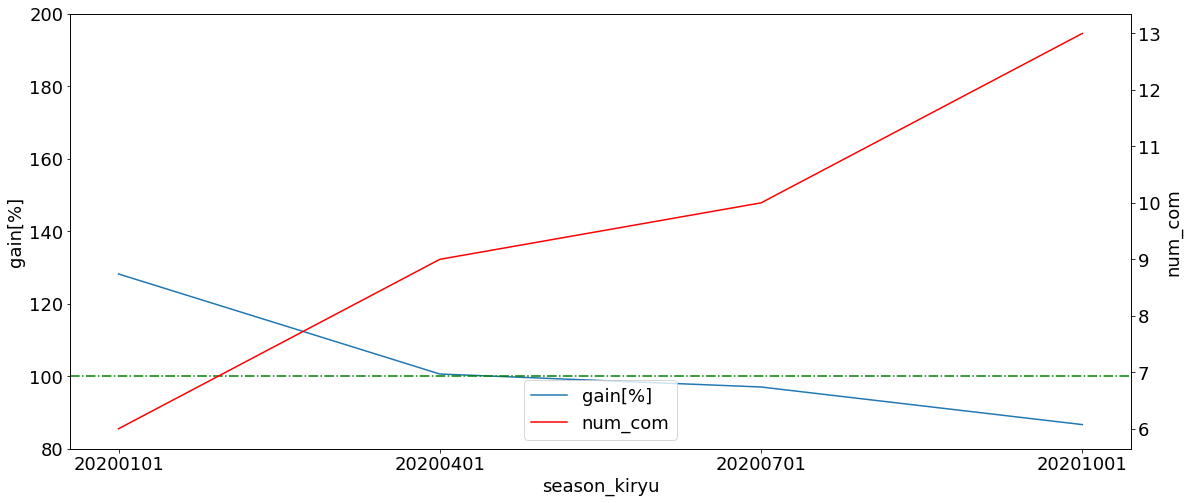

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.50it/s]

place_name: toda ========================================================================================
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20200101_V4_2.csv
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20200401_V4_2.csv
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20200701_V4_2.csv
../../bot_database/toda/model_score_toda/use_model/V4_2/use_model_toda_20201001_V4_2.csv


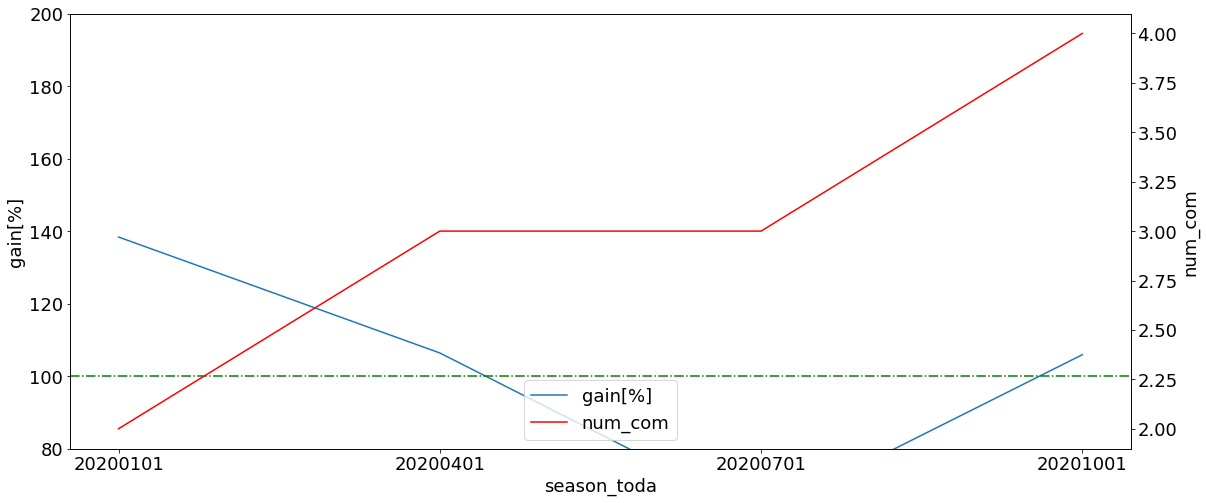

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  5.32it/s]

place_name: edogawa ========================================================================================
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20200101_V4_2.csv
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20200401_V4_2.csv
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20200701_V4_2.csv
../../bot_database/edogawa/model_score_edogawa/use_model/V4_2/use_model_edogawa_20201001_V4_2.csv


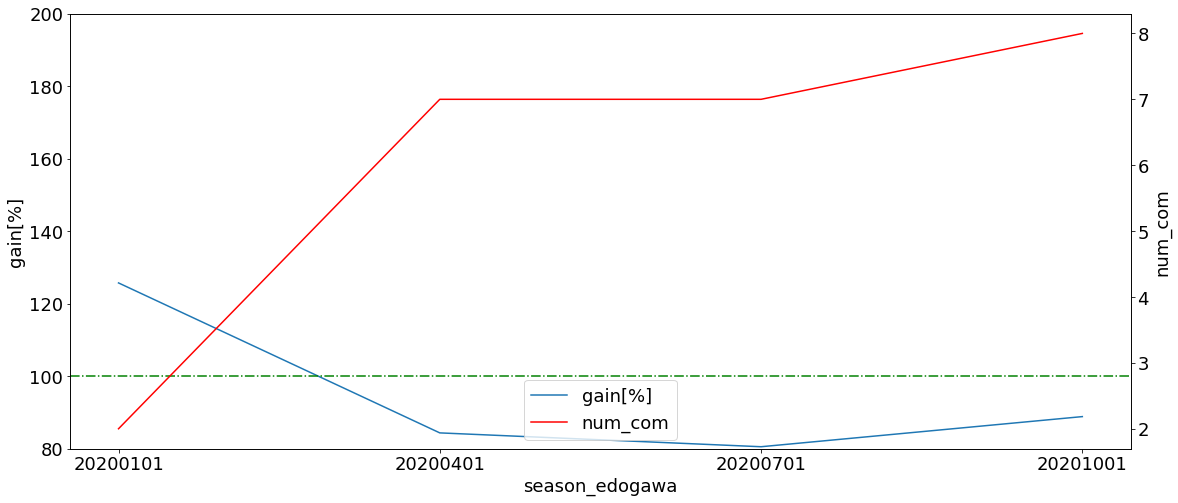

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  5.97it/s]

place_name: heiwazima ========================================================================================
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20200101_V4_2.csv
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20200401_V4_2.csv
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20200701_V4_2.csv
../../bot_database/heiwazima/model_score_heiwazima/use_model/V4_2/use_model_heiwazima_20201001_V4_2.csv


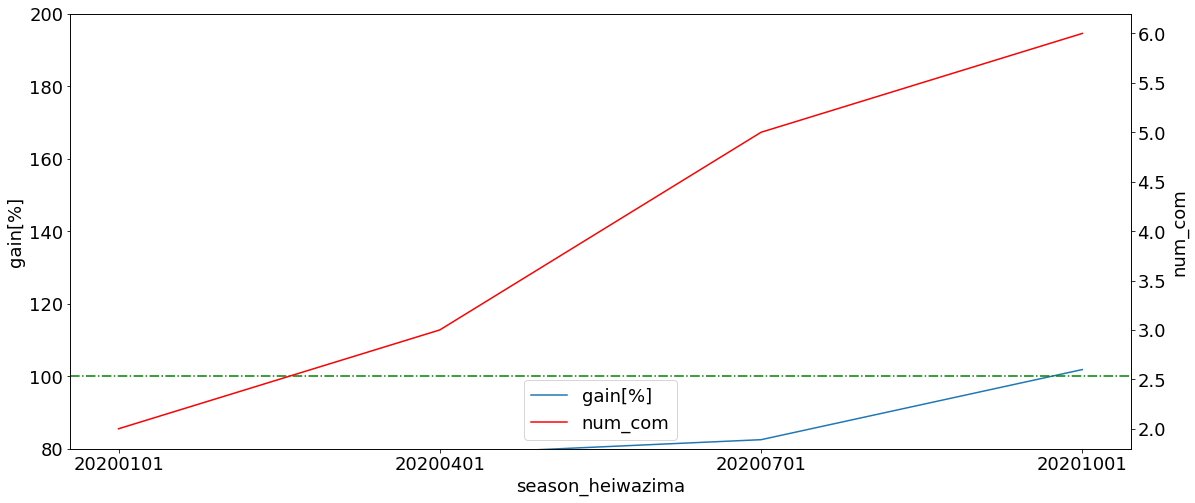

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.16it/s]

place_name: tamagawa ========================================================================================
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20200101_V4_2.csv
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20200401_V4_2.csv
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20200701_V4_2.csv
../../bot_database/tamagawa/model_score_tamagawa/use_model/V4_2/use_model_tamagawa_20201001_V4_2.csv


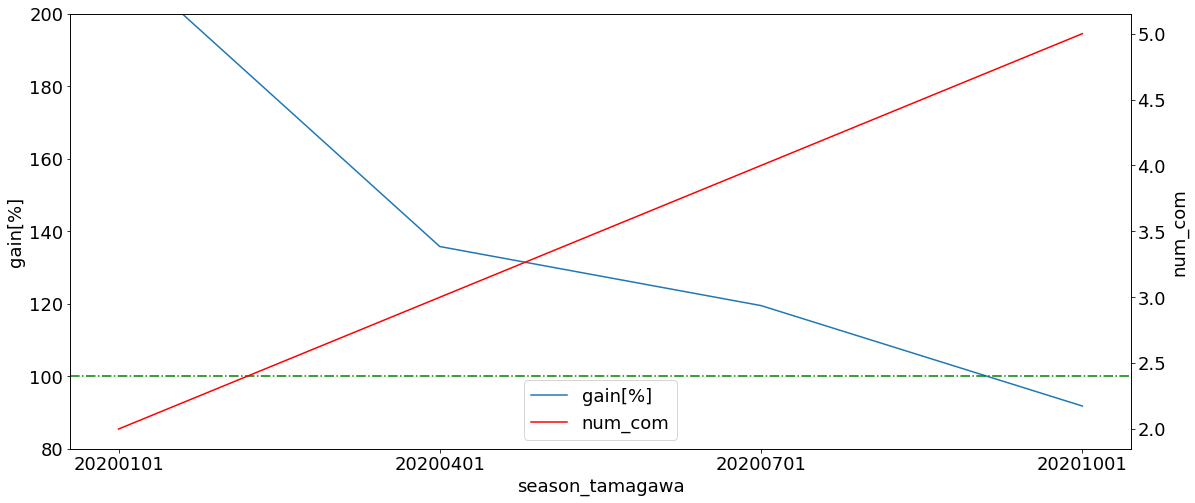

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.34it/s]

place_name: hamanako ========================================================================================
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20200101_V4_2.csv
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20200401_V4_2.csv
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20200701_V4_2.csv
../../bot_database/hamanako/model_score_hamanako/use_model/V4_2/use_model_hamanako_20201001_V4_2.csv


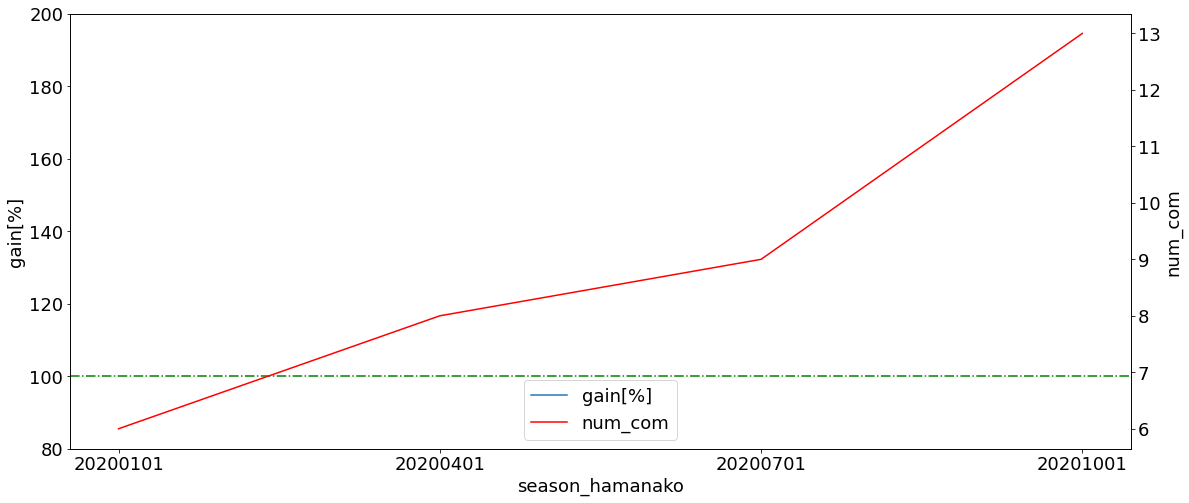

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.49it/s]

place_name: gamagori ========================================================================================
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20200101_V4_2.csv
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20200401_V4_2.csv
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20200701_V4_2.csv
../../bot_database/gamagori/model_score_gamagori/use_model/V4_2/use_model_gamagori_20201001_V4_2.csv


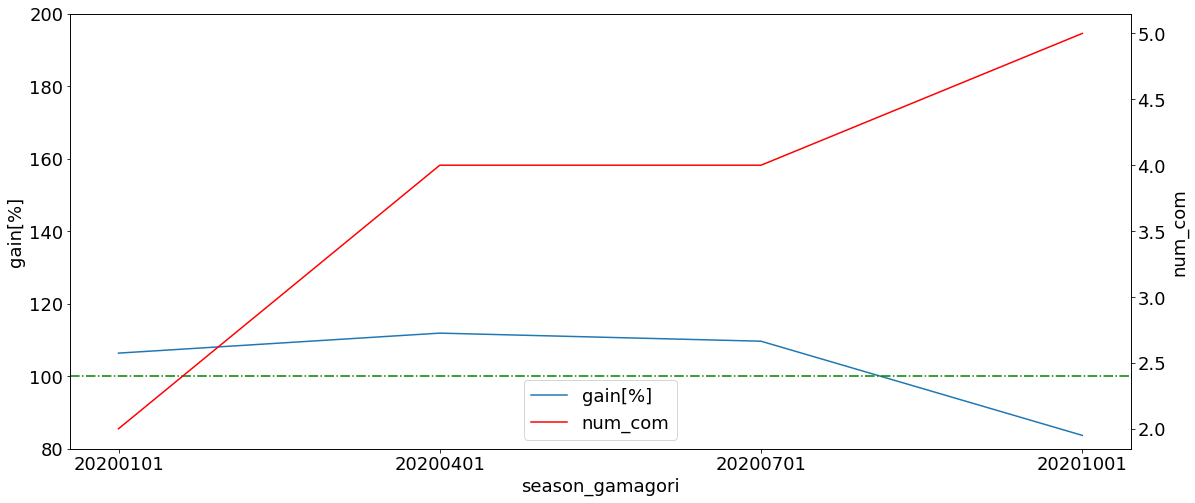

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.50it/s]

place_name: tokoname ========================================================================================
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20200101_V4_2.csv
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20200401_V4_2.csv
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20200701_V4_2.csv
../../bot_database/tokoname/model_score_tokoname/use_model/V4_2/use_model_tokoname_20201001_V4_2.csv


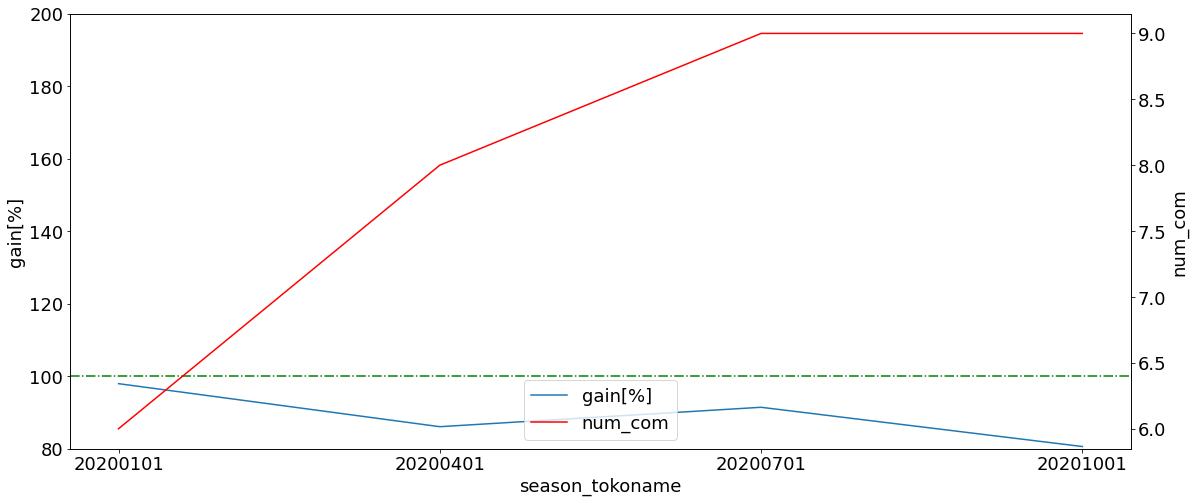

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  6.52it/s]

place_name: tu ========================================================================================
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20200101_V4_2.csv
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20200401_V4_2.csv
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20200701_V4_2.csv
../../bot_database/tu/model_score_tu/use_model/V4_2/use_model_tu_20201001_V4_2.csv


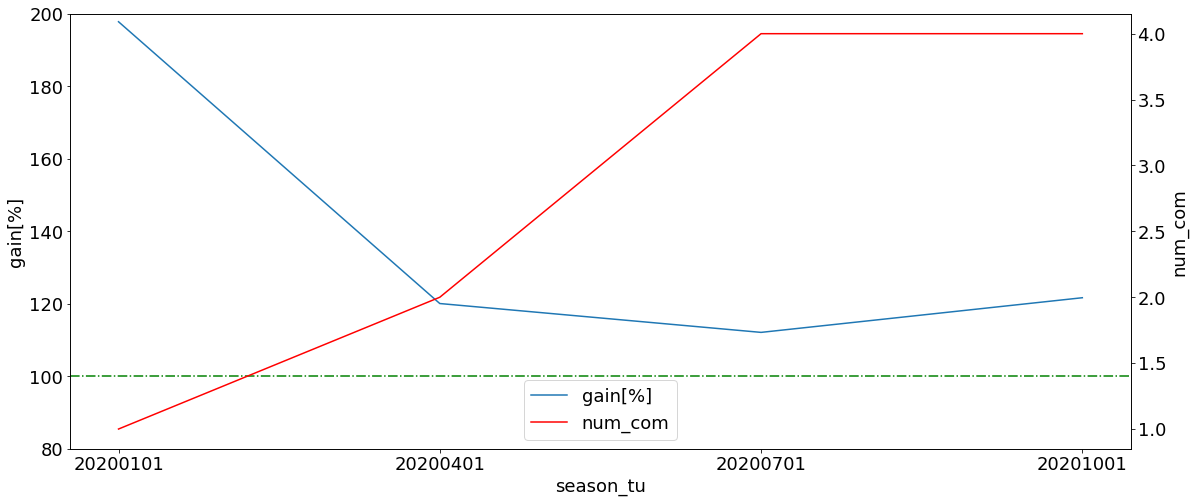

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  6.58it/s]

place_name: mikuni ========================================================================================
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20200101_V4_2.csv
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20200401_V4_2.csv
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20200701_V4_2.csv
../../bot_database/mikuni/model_score_mikuni/use_model/V4_2/use_model_mikuni_20201001_V4_2.csv


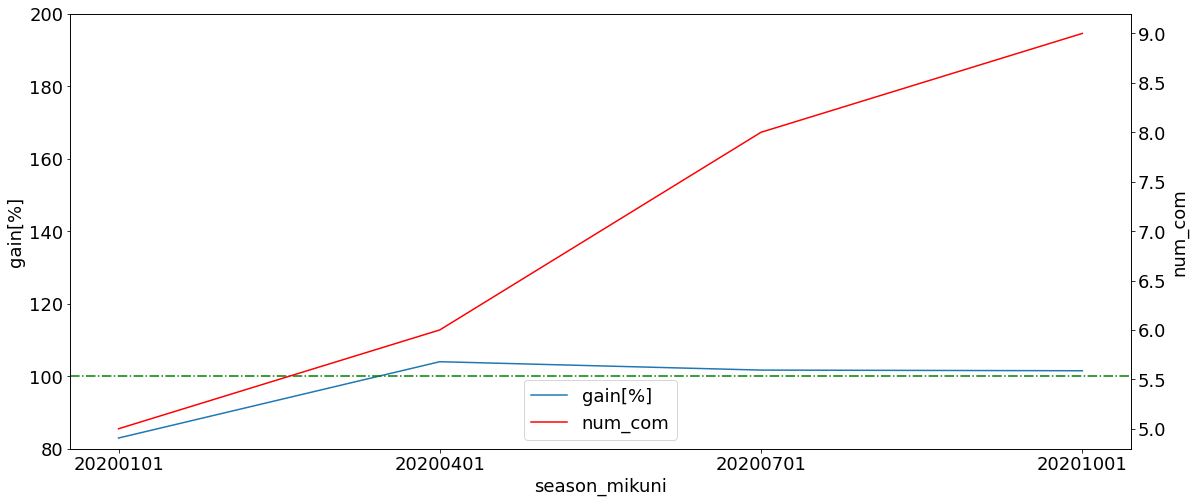

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.35it/s]


In [25]:

version='V4_2'
for place_name in tqdm(place_names[:10]):
    print('place_name:',place_name,'========================================================================================')
    gain_arr=[0]*4
    n_com_arr=[0]*4
    date_arr=[0]*4
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        print(dir_path)
        use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
        s_t_use=use_models['total_use_final'].sum()
        s_t_get=use_models['total_get_final'].sum()
        s_gain=(s_t_get/s_t_use)*100
        gain_arr[i]=s_gain
        n_com_arr[i]=len(use_models)
        date_arr[i]=now_ym
    x_n='season_{place_name}'.format(place_name=place_name)
    y1_n='gain[%]'
    y2_n='num_com'
    twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

# 全会場版なのは変わらず，相関係数の算出部分を変更した

In [26]:
#相関係数と全体分析の結果をもとに最終的に使用するモデルを選定する
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列
#絶対に固定のパラメータたち
plus_m_th=2
#plus_m_th=3
num_hit_th=5
version='V4_2'
mode='model_score_'
mode_type='recent'
#コード本文
for place_name in tqdm(place_names[:10]):
    csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
    totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
    totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)
    print('place_name:',place_name,'========================================================================================')
    #閾値の取得
    th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>2].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]#plusだったcom数の平均が２より大きい
    print(th_s)
    dates=[datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d') for i in range(4)]#今回のテストで使用する日付たち
    select_model_df=pd.DataFrame()
    
    #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        #print('now_date:',now_ym)
        dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
        model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
        model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
        #選定したパラメータで切り落とし
        selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
        selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
        selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
        selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
        select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
        
        
        #偏差値評価を用いた実際に使用するモデルの切り抜き(方針：使用する区間の１つ前の区間(test5,final3の区間))をもとに相関係数を算出
        #試しに一年間の相関係数を加算してみる
        feature_weights=pd.Series(dtype='object')
        for i_2 in range(4):
            i2_now_ym=datetime.datetime(year=2020, month=1+(i_2*3),day=1).strftime('%Y%m%d')
            use_date=dates[i-1]#一つ前の区間の日付を切り抜く
            dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{place_name}_{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=i2_now_ym,version=version)
            #print(dir_path)
            model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
            model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
            #決めのパラメータでいったん切り落とし
            model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
            model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
            version_corr_df=model_score_df.corr()
            if len(feature_weights)==0:
                feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
            else:
                feature_weights=feature_weights+version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
        display(feature_weights)
        model_std_score_df=add_std_score(select_model_df,feature_weights)


        use_models=select_use_model(model_std_score_df)#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        use_models.to_csv(dir_path)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

place_name: kiryu ========================================================================================
minus_model_per_mean                62.135142
num_plus_com_mean                    4.750000
num_plus_model_mean                122.250000
gain_th                            100.000000
gain_std_th                        130.000000
hit_per_th                           0.000000
hit_std_th                           0.400000
num_hit_th                           3.000000
st_20200101_minus_per(model)        47.596154
st_20200101_num_plus_com            10.000000
st_20200101_num_plus_model(row)    218.000000
st_20200401_minus_per(model)        66.855524
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)    117.000000
st_20200701_minus_per(model)        77.200000
st_20200701_num_plus_com             5.000000
st_20200701_num_plus_model(row)     57.000000
st_20201001_minus_per(model)        56.888889
st_20201001_num_plus_com             2.000000
st_20201001_num_plu

total_get_test         -0.030858
total_use_test         -0.015019
num_com_test           -0.632185
num_pred_test          -0.015019
gain_test               0.230069
gain_std_test           0.394476
num_hit_test           -0.022984
buy_hit_per_test       -0.066599
buy_hit_per_std_test    0.269293
plus_month_num_test    -0.191719
diff_mea_med_test      -0.064640
Name: gain_final, dtype: float64

total_get_test         -0.030858
total_use_test         -0.015019
num_com_test           -0.632185
num_pred_test          -0.015019
gain_test               0.230069
gain_std_test           0.394476
num_hit_test           -0.022984
buy_hit_per_test       -0.066599
buy_hit_per_std_test    0.269293
plus_month_num_test    -0.191719
diff_mea_med_test      -0.064640
Name: gain_final, dtype: float64

total_get_test         -0.030858
total_use_test         -0.015019
num_com_test           -0.632185
num_pred_test          -0.015019
gain_test               0.230069
gain_std_test           0.394476
num_hit_test           -0.022984
buy_hit_per_test       -0.066599
buy_hit_per_std_test    0.269293
plus_month_num_test    -0.191719
diff_mea_med_test      -0.064640
Name: gain_final, dtype: float64

total_get_test         -0.030858
total_use_test         -0.015019
num_com_test           -0.632185
num_pred_test          -0.015019
gain_test               0.230069
gain_std_test           0.394476
num_hit_test           -0.022984
buy_hit_per_test       -0.066599
buy_hit_per_std_test    0.269293
plus_month_num_test    -0.191719
diff_mea_med_test      -0.064640
Name: gain_final, dtype: float64

 10%|████████▎                                                                          | 1/10 [00:01<00:09,  1.09s/it]

place_name: toda ========================================================================================
minus_model_per_mean               16.954685
num_plus_com_mean                   2.250000
num_plus_model_mean                20.750000
gain_th                            96.000000
gain_std_th                        85.000000
hit_per_th                          6.000000
hit_std_th                          1.600000
num_hit_th                          5.000000
st_20200101_minus_per(model)        9.523810
st_20200101_num_plus_com            3.000000
st_20200101_num_plus_model(row)    38.000000
st_20200401_minus_per(model)       35.714286
st_20200401_num_plus_com            2.000000
st_20200401_num_plus_model(row)     9.000000
st_20200701_minus_per(model)       22.580645
st_20200701_num_plus_com            2.000000
st_20200701_num_plus_model(row)    24.000000
st_20201001_minus_per(model)        0.000000
st_20201001_num_plus_com            2.000000
st_20201001_num_plus_model(row)    12.0

total_get_test          0.290102
total_use_test          0.001622
num_com_test           -0.199328
num_pred_test           0.001622
gain_test               0.066984
gain_std_test           0.614909
num_hit_test           -0.170725
buy_hit_per_test       -0.222613
buy_hit_per_std_test    0.254199
plus_month_num_test    -0.510252
diff_mea_med_test      -0.344116
Name: gain_final, dtype: float64

total_get_test          0.290102
total_use_test          0.001622
num_com_test           -0.199328
num_pred_test           0.001622
gain_test               0.066984
gain_std_test           0.614909
num_hit_test           -0.170725
buy_hit_per_test       -0.222613
buy_hit_per_std_test    0.254199
plus_month_num_test    -0.510252
diff_mea_med_test      -0.344116
Name: gain_final, dtype: float64

total_get_test          0.290102
total_use_test          0.001622
num_com_test           -0.199328
num_pred_test           0.001622
gain_test               0.066984
gain_std_test           0.614909
num_hit_test           -0.170725
buy_hit_per_test       -0.222613
buy_hit_per_std_test    0.254199
plus_month_num_test    -0.510252
diff_mea_med_test      -0.344116
Name: gain_final, dtype: float64

total_get_test          0.290102
total_use_test          0.001622
num_com_test           -0.199328
num_pred_test           0.001622
gain_test               0.066984
gain_std_test           0.614909
num_hit_test           -0.170725
buy_hit_per_test       -0.222613
buy_hit_per_std_test    0.254199
plus_month_num_test    -0.510252
diff_mea_med_test      -0.344116
Name: gain_final, dtype: float64

 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.05it/s]

place_name: edogawa ========================================================================================
minus_model_per_mean                30.134409
num_plus_com_mean                    2.250000
num_plus_model_mean                 12.250000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           4.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        36.666667
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)     19.000000
st_20200401_minus_per(model)        83.870968
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     25.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      1.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_p

total_get_test          0.123861
total_use_test         -0.370768
num_com_test           -0.087772
num_pred_test          -0.370768
gain_test               0.472803
gain_std_test           0.318894
num_hit_test           -0.275035
buy_hit_per_test       -0.108274
buy_hit_per_std_test   -0.115380
plus_month_num_test     0.321293
diff_mea_med_test      -0.403369
Name: gain_final, dtype: float64

total_get_test          0.123861
total_use_test         -0.370768
num_com_test           -0.087772
num_pred_test          -0.370768
gain_test               0.472803
gain_std_test           0.318894
num_hit_test           -0.275035
buy_hit_per_test       -0.108274
buy_hit_per_std_test   -0.115380
plus_month_num_test     0.321293
diff_mea_med_test      -0.403369
Name: gain_final, dtype: float64

total_get_test          0.123861
total_use_test         -0.370768
num_com_test           -0.087772
num_pred_test          -0.370768
gain_test               0.472803
gain_std_test           0.318894
num_hit_test           -0.275035
buy_hit_per_test       -0.108274
buy_hit_per_std_test   -0.115380
plus_month_num_test     0.321293
diff_mea_med_test      -0.403369
Name: gain_final, dtype: float64

total_get_test          0.123861
total_use_test         -0.370768
num_com_test           -0.087772
num_pred_test          -0.370768
gain_test               0.472803
gain_std_test           0.318894
num_hit_test           -0.275035
buy_hit_per_test       -0.108274
buy_hit_per_std_test   -0.115380
plus_month_num_test     0.321293
diff_mea_med_test      -0.403369
Name: gain_final, dtype: float64

 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.04it/s]

place_name: heiwazima ========================================================================================
minus_model_per_mean                49.935985
num_plus_com_mean                    2.500000
num_plus_model_mean                 23.000000
gain_th                            160.000000
gain_std_th                        190.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        85.416667
st_20200101_num_plus_com             2.000000
st_20200101_num_plus_model(row)      7.000000
st_20200401_minus_per(model)         0.000000
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)      9.000000
st_20200701_minus_per(model)        72.727273
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        41.600000
st_20201001_num_plus_com             4.000000
st_20201001_num

total_get_test         -0.546666
total_use_test         -0.482454
num_com_test            0.265231
num_pred_test          -0.482454
gain_test              -0.062987
gain_std_test           0.112860
num_hit_test            0.174068
buy_hit_per_test        0.601473
buy_hit_per_std_test    0.970791
plus_month_num_test    -0.019721
diff_mea_med_test      -0.653420
Name: gain_final, dtype: float64

total_get_test         -0.546666
total_use_test         -0.482454
num_com_test            0.265231
num_pred_test          -0.482454
gain_test              -0.062987
gain_std_test           0.112860
num_hit_test            0.174068
buy_hit_per_test        0.601473
buy_hit_per_std_test    0.970791
plus_month_num_test    -0.019721
diff_mea_med_test      -0.653420
Name: gain_final, dtype: float64

total_get_test         -0.546666
total_use_test         -0.482454
num_com_test            0.265231
num_pred_test          -0.482454
gain_test              -0.062987
gain_std_test           0.112860
num_hit_test            0.174068
buy_hit_per_test        0.601473
buy_hit_per_std_test    0.970791
plus_month_num_test    -0.019721
diff_mea_med_test      -0.653420
Name: gain_final, dtype: float64

total_get_test         -0.546666
total_use_test         -0.482454
num_com_test            0.265231
num_pred_test          -0.482454
gain_test              -0.062987
gain_std_test           0.112860
num_hit_test            0.174068
buy_hit_per_test        0.601473
buy_hit_per_std_test    0.970791
plus_month_num_test    -0.019721
diff_mea_med_test      -0.653420
Name: gain_final, dtype: float64

 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.06it/s]

place_name: tamagawa ========================================================================================
minus_model_per_mean                35.136901
num_plus_com_mean                    2.500000
num_plus_model_mean                 52.250000
gain_th                            108.000000
gain_std_th                        115.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             3.000000
st_20200101_num_plus_model(row)    109.000000
st_20200401_minus_per(model)        92.721519
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)     23.000000
st_20200701_minus_per(model)        47.826087
st_20200701_num_plus_com             4.000000
st_20200701_num_plus_model(row)     72.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_

total_get_test         -0.072053
total_use_test         -0.337373
num_com_test            0.358922
num_pred_test          -0.337373
gain_test               0.221276
gain_std_test           0.259485
num_hit_test            0.232382
buy_hit_per_test        0.695173
buy_hit_per_std_test    0.712268
plus_month_num_test     0.198514
diff_mea_med_test      -0.008949
Name: gain_final, dtype: float64

total_get_test         -0.072053
total_use_test         -0.337373
num_com_test            0.358922
num_pred_test          -0.337373
gain_test               0.221276
gain_std_test           0.259485
num_hit_test            0.232382
buy_hit_per_test        0.695173
buy_hit_per_std_test    0.712268
plus_month_num_test     0.198514
diff_mea_med_test      -0.008949
Name: gain_final, dtype: float64

total_get_test         -0.072053
total_use_test         -0.337373
num_com_test            0.358922
num_pred_test          -0.337373
gain_test               0.221276
gain_std_test           0.259485
num_hit_test            0.232382
buy_hit_per_test        0.695173
buy_hit_per_std_test    0.712268
plus_month_num_test     0.198514
diff_mea_med_test      -0.008949
Name: gain_final, dtype: float64

total_get_test         -0.072053
total_use_test         -0.337373
num_com_test            0.358922
num_pred_test          -0.337373
gain_test               0.221276
gain_std_test           0.259485
num_hit_test            0.232382
buy_hit_per_test        0.695173
buy_hit_per_std_test    0.712268
plus_month_num_test     0.198514
diff_mea_med_test      -0.008949
Name: gain_final, dtype: float64

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.08it/s]

place_name: hamanako ========================================================================================
minus_model_per_mean                51.939811
num_plus_com_mean                    2.250000
num_plus_model_mean                 24.750000
gain_th                            124.000000
gain_std_th                        235.000000
hit_per_th                           2.000000
hit_std_th                           0.800000
num_hit_th                           8.000000
st_20200101_minus_per(model)        28.571429
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)     55.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             1.000000
st_20200701_num_plus_model(row)      3.000000
st_20201001_minus_per(model)        79.187817
st_20201001_num_plus_com             4.000000
st_20201001_num_

total_get_test         -0.206199
total_use_test          0.423091
num_com_test            0.801947
num_pred_test           0.423091
gain_test              -0.810593
gain_std_test          -0.673417
num_hit_test            0.745806
buy_hit_per_test        0.198467
buy_hit_per_std_test   -0.127169
plus_month_num_test    -0.354789
diff_mea_med_test      -0.103461
Name: gain_final, dtype: float64

total_get_test         -0.206199
total_use_test          0.423091
num_com_test            0.801947
num_pred_test           0.423091
gain_test              -0.810593
gain_std_test          -0.673417
num_hit_test            0.745806
buy_hit_per_test        0.198467
buy_hit_per_std_test   -0.127169
plus_month_num_test    -0.354789
diff_mea_med_test      -0.103461
Name: gain_final, dtype: float64

total_get_test         -0.206199
total_use_test          0.423091
num_com_test            0.801947
num_pred_test           0.423091
gain_test              -0.810593
gain_std_test          -0.673417
num_hit_test            0.745806
buy_hit_per_test        0.198467
buy_hit_per_std_test   -0.127169
plus_month_num_test    -0.354789
diff_mea_med_test      -0.103461
Name: gain_final, dtype: float64

total_get_test         -0.206199
total_use_test          0.423091
num_com_test            0.801947
num_pred_test           0.423091
gain_test              -0.810593
gain_std_test          -0.673417
num_hit_test            0.745806
buy_hit_per_test        0.198467
buy_hit_per_std_test   -0.127169
plus_month_num_test    -0.354789
diff_mea_med_test      -0.103461
Name: gain_final, dtype: float64

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.04it/s]

place_name: gamagori ========================================================================================
minus_model_per_mean                33.069829
num_plus_com_mean                    2.250000
num_plus_model_mean                 48.000000
gain_th                            108.000000
gain_std_th                        130.000000
hit_per_th                           6.000000
hit_std_th                           1.200000
num_hit_th                           5.000000
st_20200101_minus_per(model)        23.188406
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)    159.000000
st_20200401_minus_per(model)         9.090909
st_20200401_num_plus_com             4.000000
st_20200401_num_plus_model(row)     30.000000
st_20200701_minus_per(model)       100.000000
st_20200701_num_plus_com             0.000000
st_20200701_num_plus_model(row)      0.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             1.000000
st_20201001_num_

total_get_test         -0.597950
total_use_test         -0.195754
num_com_test            0.246462
num_pred_test          -0.195754
gain_test              -0.555241
gain_std_test           0.219965
num_hit_test           -0.261891
buy_hit_per_test       -0.138275
buy_hit_per_std_test    0.017156
plus_month_num_test    -0.685570
diff_mea_med_test       0.281700
Name: gain_final, dtype: float64

total_get_test         -0.597950
total_use_test         -0.195754
num_com_test            0.246462
num_pred_test          -0.195754
gain_test              -0.555241
gain_std_test           0.219965
num_hit_test           -0.261891
buy_hit_per_test       -0.138275
buy_hit_per_std_test    0.017156
plus_month_num_test    -0.685570
diff_mea_med_test       0.281700
Name: gain_final, dtype: float64

total_get_test         -0.597950
total_use_test         -0.195754
num_com_test            0.246462
num_pred_test          -0.195754
gain_test              -0.555241
gain_std_test           0.219965
num_hit_test           -0.261891
buy_hit_per_test       -0.138275
buy_hit_per_std_test    0.017156
plus_month_num_test    -0.685570
diff_mea_med_test       0.281700
Name: gain_final, dtype: float64

total_get_test         -0.597950
total_use_test         -0.195754
num_com_test            0.246462
num_pred_test          -0.195754
gain_test              -0.555241
gain_std_test           0.219965
num_hit_test           -0.261891
buy_hit_per_test       -0.138275
buy_hit_per_std_test    0.017156
plus_month_num_test    -0.685570
diff_mea_med_test       0.281700
Name: gain_final, dtype: float64

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.07it/s]

place_name: tokoname ========================================================================================
minus_model_per_mean                39.015152
num_plus_com_mean                    2.250000
num_plus_model_mean                 22.000000
gain_th                            144.000000
gain_std_th                        160.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           3.000000
st_20200101_minus_per(model)        39.393939
st_20200101_num_plus_com             5.000000
st_20200101_num_plus_model(row)     80.000000
st_20200401_minus_per(model)       100.000000
st_20200401_num_plus_com             0.000000
st_20200401_num_plus_model(row)      0.000000
st_20200701_minus_per(model)        16.666667
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)      5.000000
st_20201001_minus_per(model)         0.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_

total_get_test         -1.059176
total_use_test         -0.369977
num_com_test           -0.393126
num_pred_test          -0.369977
gain_test              -0.799402
gain_std_test          -0.785860
num_hit_test           -0.348460
buy_hit_per_test       -0.042122
buy_hit_per_std_test    0.239018
plus_month_num_test    -0.248235
diff_mea_med_test      -0.712729
Name: gain_final, dtype: float64

total_get_test         -1.059176
total_use_test         -0.369977
num_com_test           -0.393126
num_pred_test          -0.369977
gain_test              -0.799402
gain_std_test          -0.785860
num_hit_test           -0.348460
buy_hit_per_test       -0.042122
buy_hit_per_std_test    0.239018
plus_month_num_test    -0.248235
diff_mea_med_test      -0.712729
Name: gain_final, dtype: float64

total_get_test         -1.059176
total_use_test         -0.369977
num_com_test           -0.393126
num_pred_test          -0.369977
gain_test              -0.799402
gain_std_test          -0.785860
num_hit_test           -0.348460
buy_hit_per_test       -0.042122
buy_hit_per_std_test    0.239018
plus_month_num_test    -0.248235
diff_mea_med_test      -0.712729
Name: gain_final, dtype: float64

total_get_test         -1.059176
total_use_test         -0.369977
num_com_test           -0.393126
num_pred_test          -0.369977
gain_test              -0.799402
gain_std_test          -0.785860
num_hit_test           -0.348460
buy_hit_per_test       -0.042122
buy_hit_per_std_test    0.239018
plus_month_num_test    -0.248235
diff_mea_med_test      -0.712729
Name: gain_final, dtype: float64

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.04it/s]

place_name: tu ========================================================================================
minus_model_per_mean                26.960784
num_plus_com_mean                    2.250000
num_plus_model_mean                  7.000000
gain_th                            148.000000
gain_std_th                        175.000000
hit_per_th                           4.000000
hit_std_th                           1.600000
num_hit_th                           8.000000
st_20200101_minus_per(model)         0.000000
st_20200101_num_plus_com             1.000000
st_20200101_num_plus_model(row)      8.000000
st_20200401_minus_per(model)        41.666667
st_20200401_num_plus_com             3.000000
st_20200401_num_plus_model(row)      7.000000
st_20200701_minus_per(model)        41.176471
st_20200701_num_plus_com             3.000000
st_20200701_num_plus_model(row)     10.000000
st_20201001_minus_per(model)        25.000000
st_20201001_num_plus_com             2.000000
st_20201001_num_plus_m

total_get_test          0.465508
total_use_test          0.654869
num_com_test            0.457159
num_pred_test           0.654869
gain_test               0.000950
gain_std_test          -0.172852
num_hit_test            0.640388
buy_hit_per_test        0.341128
buy_hit_per_std_test   -0.099774
plus_month_num_test    -0.668950
diff_mea_med_test       0.042121
Name: gain_final, dtype: float64

total_get_test          0.465508
total_use_test          0.654869
num_com_test            0.457159
num_pred_test           0.654869
gain_test               0.000950
gain_std_test          -0.172852
num_hit_test            0.640388
buy_hit_per_test        0.341128
buy_hit_per_std_test   -0.099774
plus_month_num_test    -0.668950
diff_mea_med_test       0.042121
Name: gain_final, dtype: float64

total_get_test          0.465508
total_use_test          0.654869
num_com_test            0.457159
num_pred_test           0.654869
gain_test               0.000950
gain_std_test          -0.172852
num_hit_test            0.640388
buy_hit_per_test        0.341128
buy_hit_per_std_test   -0.099774
plus_month_num_test    -0.668950
diff_mea_med_test       0.042121
Name: gain_final, dtype: float64

total_get_test          0.465508
total_use_test          0.654869
num_com_test            0.457159
num_pred_test           0.654869
gain_test               0.000950
gain_std_test          -0.172852
num_hit_test            0.640388
buy_hit_per_test        0.341128
buy_hit_per_std_test   -0.099774
plus_month_num_test    -0.668950
diff_mea_med_test       0.042121
Name: gain_final, dtype: float64

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:08<00:00,  1.09it/s]

place_name: mikuni ========================================================================================
minus_model_per_mean               40.159193
num_plus_com_mean                   2.250000
num_plus_model_mean                20.000000
gain_th                            96.000000
gain_std_th                        70.000000
hit_per_th                          2.000000
hit_std_th                          0.800000
num_hit_th                         10.000000
st_20200101_minus_per(model)       53.571429
st_20200101_num_plus_com            1.000000
st_20200101_num_plus_model(row)    13.000000
st_20200401_minus_per(model)        0.000000
st_20200401_num_plus_com            1.000000
st_20200401_num_plus_model(row)     2.000000
st_20200701_minus_per(model)       90.163934
st_20200701_num_plus_com            3.000000
st_20200701_num_plus_model(row)     6.000000
st_20201001_minus_per(model)       16.901408
st_20201001_num_plus_com            4.000000
st_20201001_num_plus_model(row)    59

total_get_test         -0.078175
total_use_test         -0.027332
num_com_test            0.558721
num_pred_test          -0.027332
gain_test              -0.020936
gain_std_test          -0.174367
num_hit_test            0.347908
buy_hit_per_test        0.602473
buy_hit_per_std_test    0.717256
plus_month_num_test     0.171269
diff_mea_med_test       0.459368
Name: gain_final, dtype: float64

total_get_test         -0.078175
total_use_test         -0.027332
num_com_test            0.558721
num_pred_test          -0.027332
gain_test              -0.020936
gain_std_test          -0.174367
num_hit_test            0.347908
buy_hit_per_test        0.602473
buy_hit_per_std_test    0.717256
plus_month_num_test     0.171269
diff_mea_med_test       0.459368
Name: gain_final, dtype: float64

total_get_test         -0.078175
total_use_test         -0.027332
num_com_test            0.558721
num_pred_test          -0.027332
gain_test              -0.020936
gain_std_test          -0.174367
num_hit_test            0.347908
buy_hit_per_test        0.602473
buy_hit_per_std_test    0.717256
plus_month_num_test     0.171269
diff_mea_med_test       0.459368
Name: gain_final, dtype: float64

total_get_test         -0.078175
total_use_test         -0.027332
num_com_test            0.558721
num_pred_test          -0.027332
gain_test              -0.020936
gain_std_test          -0.174367
num_hit_test            0.347908
buy_hit_per_test        0.602473
buy_hit_per_std_test    0.717256
plus_month_num_test     0.171269
diff_mea_med_test       0.459368
Name: gain_final, dtype: float64

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

place_name: kiryu ========================================================================================


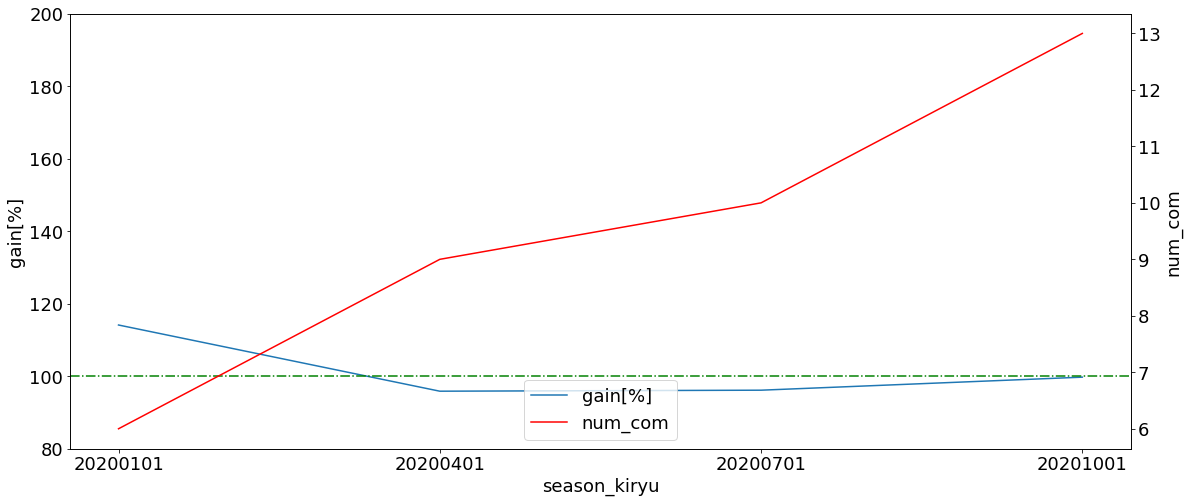

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.37it/s]

place_name: toda ========================================================================================


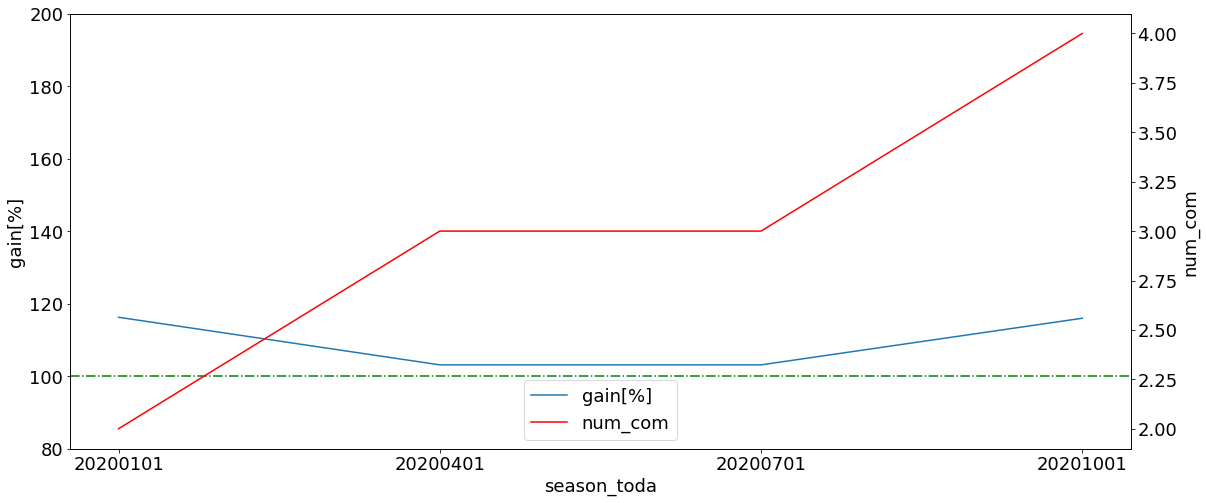

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  5.43it/s]

place_name: edogawa ========================================================================================


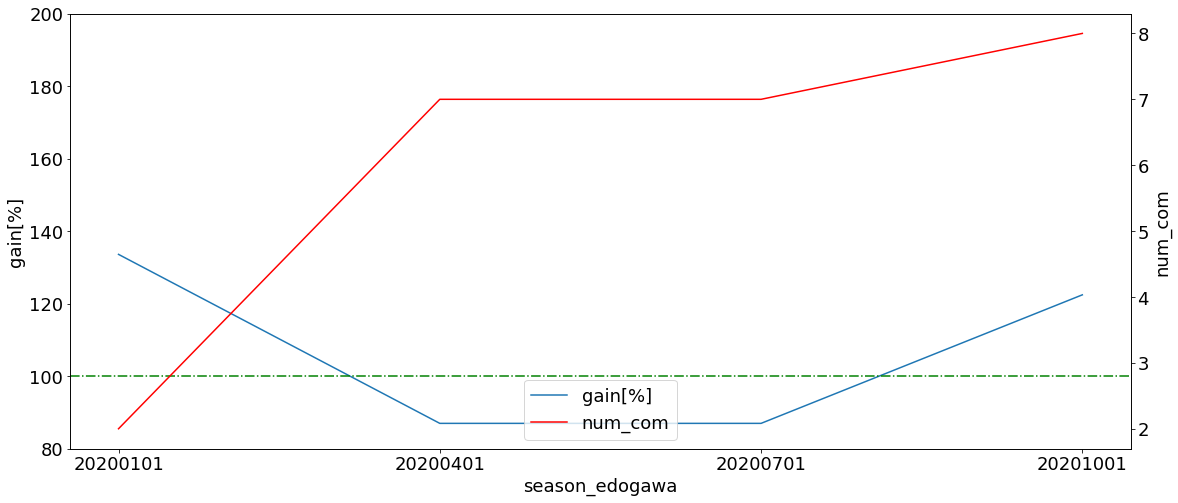

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.05it/s]

place_name: heiwazima ========================================================================================


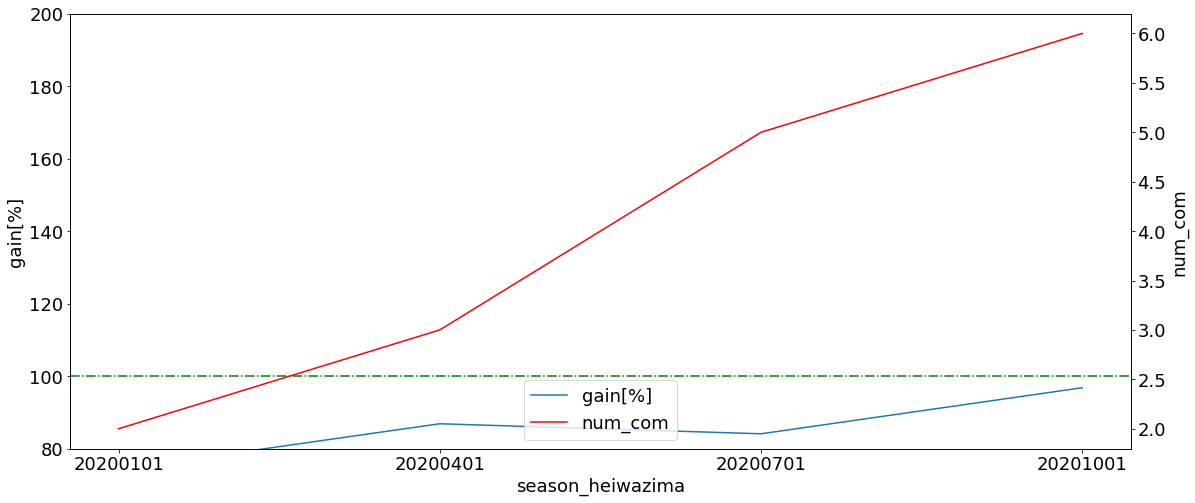

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.25it/s]

place_name: tamagawa ========================================================================================


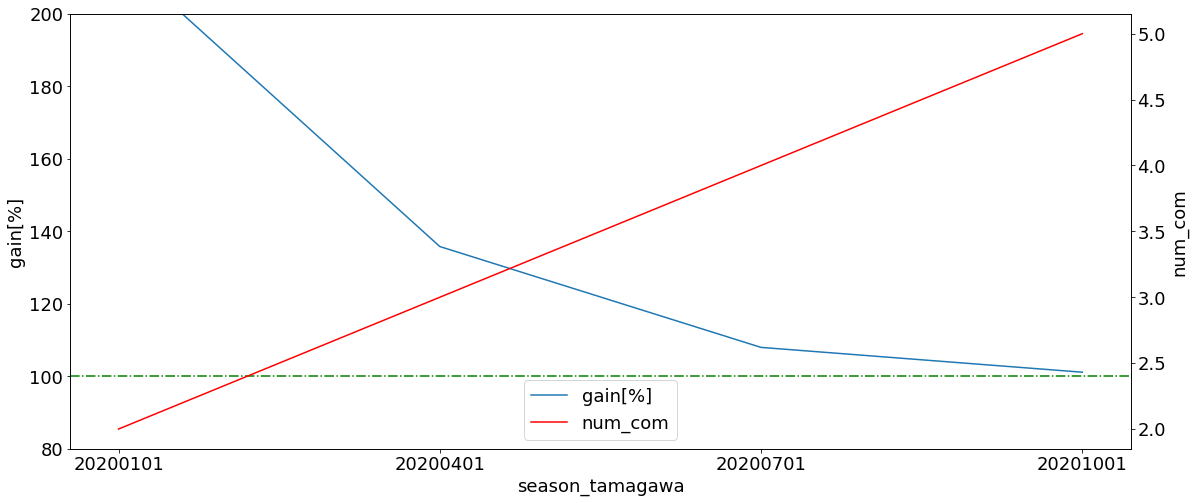

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.41it/s]

place_name: hamanako ========================================================================================


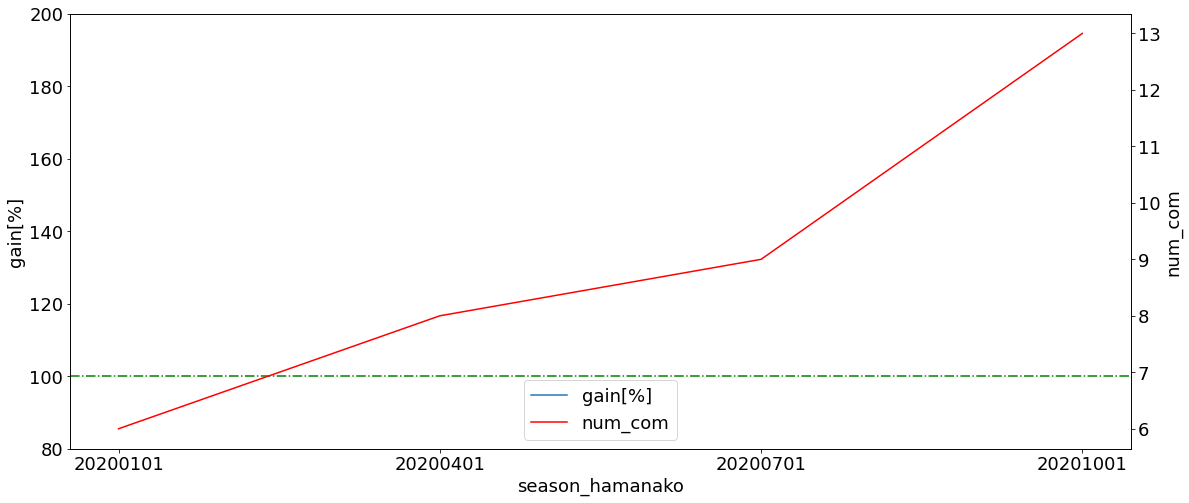

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.52it/s]

place_name: gamagori ========================================================================================


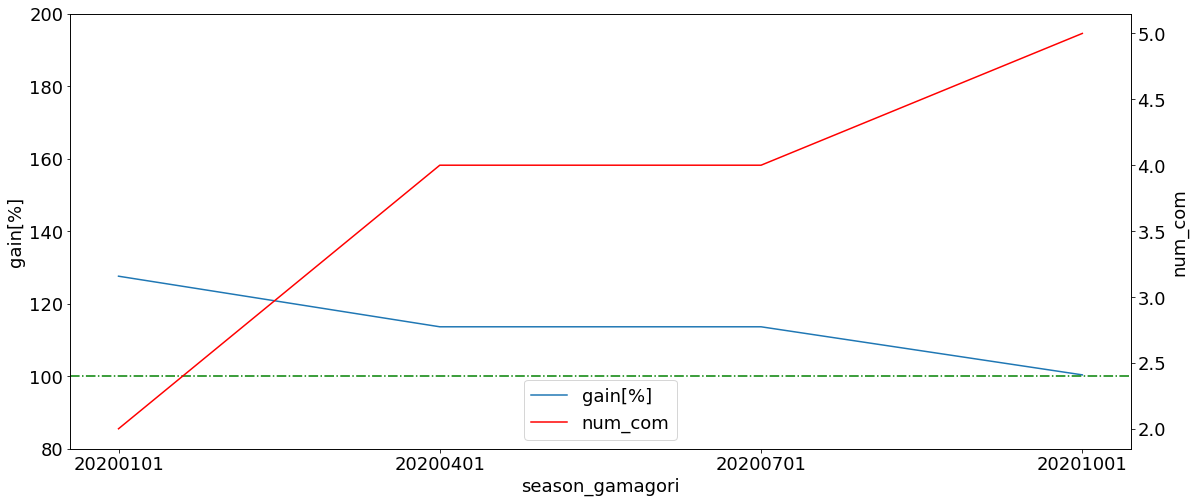

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.57it/s]

place_name: tokoname ========================================================================================


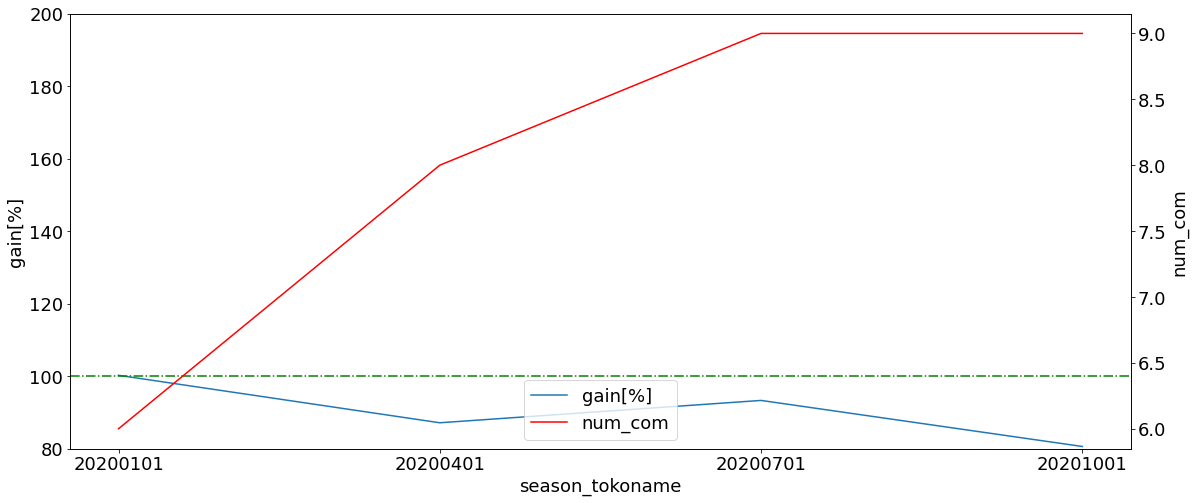

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  6.64it/s]

place_name: tu ========================================================================================


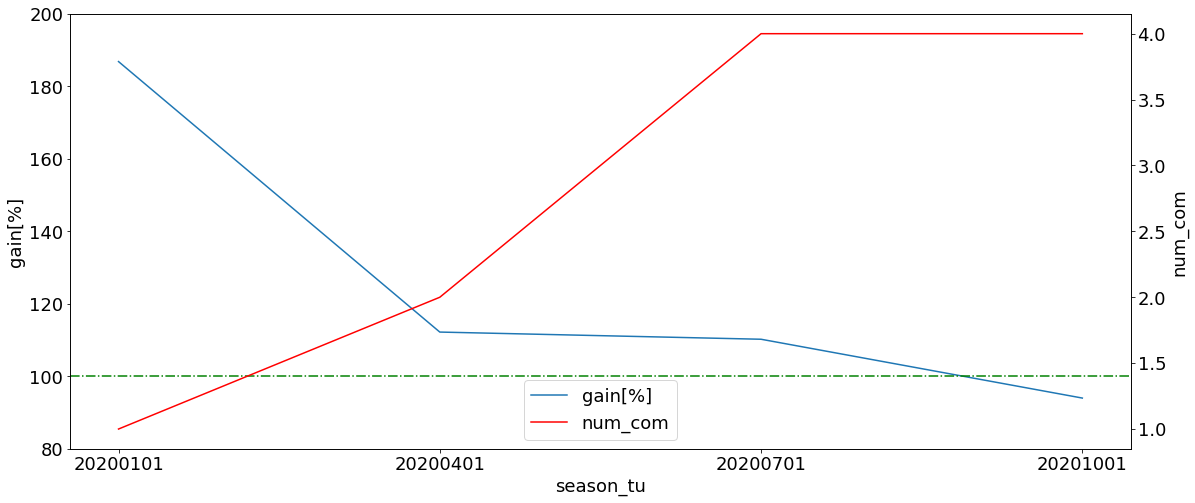

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  6.73it/s]

place_name: mikuni ========================================================================================


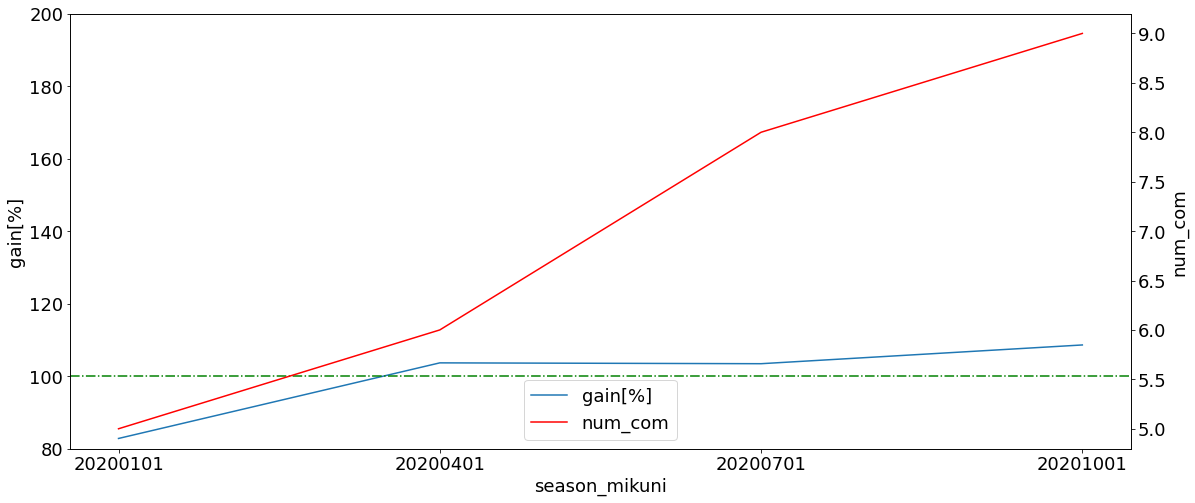

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.48it/s]


In [27]:

version='V4_2'
for place_name in tqdm(place_names[:10]):
    print('place_name:',place_name,'========================================================================================')
    gain_arr=[0]*4
    n_com_arr=[0]*4
    date_arr=[0]*4
    for i in range(4):
        now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
        dir_path = "../../bot_database/{place_name}/model_score_{place_name}/use_model/{version}/use_model_{place_name}_{now_ym}_{version}.csv".format(place_name=place_name,version=version,now_ym=now_ym)#作成したデータの書き込み先#使用するデータの読み込み
        use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
        s_t_use=use_models['total_use_final'].sum()
        s_t_get=use_models['total_get_final'].sum()
        s_gain=(s_t_get/s_t_use)*100
        gain_arr[i]=s_gain
        n_com_arr[i]=len(use_models)
        date_arr[i]=now_ym
    x_n='season_{place_name}'.format(place_name=place_name)
    y1_n='gain[%]'
    y2_n='num_com'
    twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

In [28]:
th_s

minus_model_per_mean               40.159193
num_plus_com_mean                   2.250000
num_plus_model_mean                20.000000
gain_th                            96.000000
gain_std_th                        70.000000
hit_per_th                          2.000000
hit_std_th                          0.800000
num_hit_th                         10.000000
st_20200101_minus_per(model)       53.571429
st_20200101_num_plus_com            1.000000
st_20200101_num_plus_model(row)    13.000000
st_20200401_minus_per(model)        0.000000
st_20200401_num_plus_com            1.000000
st_20200401_num_plus_model(row)     2.000000
st_20200701_minus_per(model)       90.163934
st_20200701_num_plus_com            3.000000
st_20200701_num_plus_model(row)     6.000000
st_20201001_minus_per(model)       16.901408
st_20201001_num_plus_com            4.000000
st_20201001_num_plus_model(row)    59.000000
Name: 63407, dtype: float64

## 日付を与えると区間の開始日を返してくれる関数を作る

In [29]:
def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date

In [30]:
today=datetime.date.today()
for i in range(4):
    #now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1)
    data_ym=get_season_date(now_ym)
    html_ym=data_ym- datetime.timedelta(days=1)
    print('now_ym',now_ym)
    print('data_ym',data_ym)
    print('html_ym',html_ym)
    print('===========================================================')

now_ym 2020-01-01 00:00:00
data_ym 2020-01-01 00:00:00
html_ym 2019-12-31 00:00:00
now_ym 2020-04-01 00:00:00
data_ym 2020-04-01 00:00:00
html_ym 2020-03-31 00:00:00
now_ym 2020-07-01 00:00:00
data_ym 2020-07-01 00:00:00
html_ym 2020-06-30 00:00:00
now_ym 2020-10-01 00:00:00
data_ym 2020-10-01 00:00:00
html_ym 2020-09-30 00:00:00


In [31]:
now_ym=datetime.date.today()
data_ym=get_season_date(now_ym)
html_ym=data_ym- datetime.timedelta(days=1)
print('now_ym',now_ym)
print('data_ym',data_ym)
print('html_ym',html_ym)
print('===========================================================')

now_ym 2021-11-23
data_ym 2021-10-01 00:00:00
html_ym 2021-09-30 00:00:00


In [32]:
print(today)
print(type(today))

2021-11-23
<class 'datetime.date'>


In [33]:
# # 芦屋だけでひとまず機能を完成させる
# #きめのパラメータ
# place_name='asiya'
# plus_m_th=3
# num_hit_th=5
# version='V4_2'
# mode='asiya_model_score_'
# mode_type='recent'
# csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
# totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
# totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)

# #閾値の取得
# #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]
# th_s=totol_analysis_df[(totol_analysis_df['num_plus_com_mean']>3) & (totol_analysis_df['num_hit_th']>=10)].sort_values('minus_model_per_mean').iloc[0]
# select_model_df=pd.DataFrame()
# #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
# for i in range(4):
#     now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
#     dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
#     model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
#     model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
#     #選定したパラメータで切り落とし

    
#     selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
#     selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
#     selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
#     selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
#     selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
#     print(now_ym,'=============================================')
#     display(selected_m)
#     select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
#     #偏差値評価を用いた実際に使用するモデルの切り抜き
#     model_score_df=add_std_score(selected_m)
#     use_models=select_use_model(model_score_df)
#     use_models.to_csv('csv/use_model_df_{}.csv'.format(now_ym))

# #select_model_df.to_csv('check_model2.csv', encoding='utf_8_sig')
# #相関係数の算出（範囲は-1～1）
# #version_corr_df=version_df.corr()

## 偏差値評価の機能を作る
=今までの偏差値評価部分との変更点
評価に相関係数を用いることで，finalのgainに関係のあるもの程重みを上げて，総合的な評価を自動的に行えるようにする

### 相関係数と偏差値を使ったモデル選定

In [34]:
target_com_df.to_csv('model_select.csv')

NameError: name 'target_com_df' is not defined

In [ ]:
feature_weights.index

In [ ]:
select_model_df

In [ ]:
model_score_df